Solve NS for flow around a cylinder (x,y,t) = [-1 1] * [-1 1] * (0,5)

$IC : u,v = 0$

$BC : u(-1,y) = 1$; $v(-1,y) = 0$;  $p(1,y) = 0$; $u_{cylinder} = v_{cylinder} = 0$

$u_t + (u u_x + vu_y) = −p_x + (1/Re)*(u_{xx} + u_{yy}),$

$v_t + (u v_x + v v_y) = −p_y + (1/Re)*(v_{xx} + v_{yy}),$

$u_x + v_y = 0$

Recommended algorithm: https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/blob/main/PINNs/5_BurgersEquation.ipynb

Similar code with deepxde: https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/Kovasznay_flow.py

Similar code for flow around cylinder : https://github.com/Shengfeng233/PINN-for-NS-equation/blob/sparse_data/pinn_model.py#L391

Equations:https://en.wikipedia.org/wiki/Non-dimensionalization_and_scaling_of_the_Navier%E2%80%93Stokes_equations





In [ ]:
# import scipy.io
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
# from pyDOE import lhs

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device is: ', device)

device is:  cuda:0


In [ ]:
seed = 100

In [ ]:
torch.manual_seed(seed)

class PINN_Net(nn.Module):
    def __init__(self, layer_mat):
        torch.manual_seed(seed)
        super(PINN_Net, self).__init__()
        self.layer_num = len(layer_mat) - 1
        self.base = nn.Sequential()
        for i in range(0, self.layer_num - 1):
            self.base.add_module(str(i) + "linear", nn.Linear(layer_mat[i], layer_mat[i + 1]))
            # nn.init.kaiming_normal()
            self.base.add_module(str(i) + "Activation", nn.Tanh())
        self.base.add_module(str(self.layer_num - 1) + "linear",
                             nn.Linear(layer_mat[self.layer_num - 1], layer_mat[self.layer_num]))
        # self.lam1 = nn.Parameter(torch.randn(1, requires_grad=True))
        # self.lam2 = nn.Parameter(torch.randn(1, requires_grad=True))
        self.Initial_param()

    def forward(self, x, y, t):
        X = torch.cat([x, y, t], 1).requires_grad_(True)
        predict = self.base(X)
        return predict

    def Initial_param(self):
        for name, param in self.base.named_parameters():
            if name.endswith('weight'):
                nn.init.xavier_normal_(param)
            elif name.endswith('bias'):
                nn.init.zeros_(param)

    def BC_loss_velocity(self, x, y, t, u, v):
        predict_out = self.forward(x, y, t)
        psi = predict_out[:, 0].reshape(-1, 1)
        u_predict = torch.autograd.grad(psi.sum(), y, create_graph=True, retain_graph=True)[0]
        v_predict = -torch.autograd.grad(psi.sum(), x, create_graph=True, retain_graph=True)[0]
        mse = torch.nn.MSELoss()
        mse_predict = mse(u_predict, u) + mse(v_predict, v)
        return mse_predict


    def BC_loss_pressure(self, x, y, t, p):
        # print('begin of BC_loss_without_p')
        predict_out = self.forward(x, y, t)
        p_predict = predict_out[:, 1].reshape(-1, 1)
        mse = torch.nn.MSELoss()
        mse_predict = mse(p_predict, p)
        return mse_predict



    def BC_loss_without_p(self, x, y, t, u, v):
        # print('begin of BC_loss_without_p')
        predict_out = self.forward(x, y, t)
        psi = predict_out[:, 0].reshape(-1, 1)
        # print('psi :', psi, psi.requires_grad)
        u_predict = torch.autograd.grad(psi.sum(), y, create_graph=True, retain_graph=True)[0]
        v_predict = -torch.autograd.grad(psi.sum(), x, create_graph=True, retain_graph=True)[0]
        mse = torch.nn.MSELoss()
        mse_predict = mse(u_predict, u) + mse(v_predict, v)
        return mse_predict


    def PDE_loss(self, x, y, t, Re=1000):
        # print('begin of PDE_loss')
        predict_out = self.forward(x, y, t)
        psi = predict_out[:, 0].reshape(-1, 1)
        p = predict_out[:, 1].reshape(-1, 1)
        u = torch.autograd.grad(psi.sum(), y, create_graph=True, retain_graph=True)[0]
        v = -torch.autograd.grad(psi.sum(), x, create_graph=True, retain_graph=True)[0]
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True, retain_graph=True)[0]
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
        u_y = torch.autograd.grad(u.sum(), y, create_graph=True, retain_graph=True)[0]
        v_t = torch.autograd.grad(v.sum(), t, create_graph=True, retain_graph=True)[0]
        v_x = torch.autograd.grad(v.sum(), x, create_graph=True, retain_graph=True)[0]
        v_y = torch.autograd.grad(v.sum(), y, create_graph=True, retain_graph=True)[0]
        p_x = torch.autograd.grad(p.sum(), x, create_graph=True, retain_graph=True)[0]
        p_y = torch.autograd.grad(p.sum(), y, create_graph=True, retain_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True, retain_graph=True)[0]
        u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True, retain_graph=True)[0]
        v_xx = torch.autograd.grad(v_x.sum(), x, create_graph=True, retain_graph=True)[0]
        v_yy = torch.autograd.grad(v_y.sum(), y, create_graph=True, retain_graph=True)[0]
        f_equation_x = u_t + (u * u_x + v * u_y) + p_x - 1.0/Re * (u_xx + u_yy)
        f_equation_y = v_t + (u * v_x + v * v_y) + p_y - 1.0/Re * (v_xx + v_yy)
        f_equation_continuity = u_x + v_y
        mse = torch.nn.MSELoss()
        batch_t_zeros = torch.from_numpy(np.zeros((x.shape[0], 1))).float().requires_grad_(True).to(device)
        mse_equation = mse(f_equation_x, batch_t_zeros) + mse(f_equation_y, batch_t_zeros) + mse(f_equation_continuity, batch_t_zeros)

        return mse_equation

    def total_loss(self, x_bc, y_bc, t_bc, u_bc, v_bc, x_collo, y_collo, t_collo, x_rightbc, y_rightbc, t_rightbc, p_rightbc):
         return self.BC_loss_velocity(x_bc, y_bc, t_bc, u_bc, v_bc) + self.PDE_loss(x_bc, y_bc, t_bc, Re) + self.PDE_loss(x_collo, y_collo, t_collo, Re)  +  self.BC_loss_pressure(x_rightbc, y_rightbc, t_rightbc, p_rightbc) + self.PDE_loss(x_rightbc, y_rightbc, t_rightbc, Re)
        #return self.PDE_loss(x_collo, y_collo, t_collo, Re)  +  20*self.BC_loss_pressure(x_rightbc, y_rightbc, t_rightbc, p_rightbc) + self.PDE_loss(x_rightbc, y_rightbc, t_rightbc, Re)



    def inference(self, x, y, t):
        # predict_out = self.forward(x, y, t)
        # psi = predict_out[:, 0].reshape(-1, 1)
        # p = predict_out[:, 1].reshape(-1, 1)
        # u = torch.autograd.grad(psi.sum(), y)[0]
        # v = -torch.autograd.grad(psi.sum(), x)[0]

        predict_out = self.forward(x, y, t)
        psi = predict_out[:, 0].reshape(-1, 1)
        u = torch.autograd.grad(psi.sum(), y, create_graph=True, retain_graph=True)[0]
        v = -torch.autograd.grad(psi.sum(), x, create_graph=True, retain_graph=True)[0]

        return u,v

In [ ]:
L = 2
r = 0.3 / 2
x_min, y_min, x_max, y_max = -1, -1, 1, 1
t_min, t_max = 0, 5
total_points = 100
time_steps = 16

In [ ]:
# Defining boundaries and BCs
x_rightbc = 1*torch.ones(total_points).requires_grad_(True)
y_rightbc = torch.linspace(y_min,y_max,total_points).requires_grad_(True)
t_rightbc = torch.linspace(t_min,t_max,time_steps).requires_grad_(True)
p_rightbc = 0*torch.ones(total_points).requires_grad_(True)


x_leftbc = -1*torch.ones(total_points).requires_grad_(True)
y_leftbc = torch.linspace(y_min,y_max,total_points).requires_grad_(True)

x_upperbc = torch.linspace(x_min,x_max,total_points).requires_grad_(True)
y_upperbc = +1*torch.ones(total_points).requires_grad_(True)

x_lowerbc = torch.linspace(x_min,x_max,total_points).requires_grad_(True)
y_lowerbc = -1*torch.ones(total_points).requires_grad_(True)

u_leftbc = torch.ones(total_points).requires_grad_(True)
v_leftbc = 0*torch.ones(total_points).requires_grad_(True)

u_upperbc = 0*torch.ones(total_points).requires_grad_(True)
v_upperbc = 0*torch.ones(total_points).requires_grad_(True)

u_lowerbc = 0*torch.ones(total_points).requires_grad_(True)
v_lowerbc = 0*torch.ones(total_points).requires_grad_(True)

t_bc = torch.linspace(t_min,t_max,time_steps).requires_grad_(True)

In [ ]:
x_rightbc, t_rightbc = torch.meshgrid(x_rightbc, t_bc)
y_rightbc, t_rightbc = torch.meshgrid(y_rightbc, t_bc)
p_rightbc, t_rightbc = torch.meshgrid(p_rightbc, t_bc)

x_rightbc = torch.reshape(x_rightbc, (-1, 1)).to(device)
y_rightbc = torch.reshape(y_rightbc, (-1, 1)).to(device)
t_rightbc = torch.reshape(t_rightbc, (-1, 1)).to(device)
p_rightbc = torch.reshape(p_rightbc, (-1, 1)).to(device)

x_rightbc.shape, y_rightbc.shape, t_rightbc.shape, p_rightbc.shape

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]))

In [ ]:
x_leftbc, t_leftbc = torch.meshgrid(x_leftbc, t_bc)
y_leftbc, t_leftbc = torch.meshgrid(y_leftbc, t_bc)
u_leftbc, t_leftbc = torch.meshgrid(u_leftbc, t_bc)
v_leftbc, t_leftbc = torch.meshgrid(v_leftbc, t_bc)

x_leftbc = torch.reshape(x_leftbc, (-1, 1))
y_leftbc = torch.reshape(y_leftbc, (-1, 1))
t_leftbc = torch.reshape(t_leftbc, (-1, 1))
u_leftbc = torch.reshape(u_leftbc, (-1, 1))
v_leftbc = torch.reshape(v_leftbc, (-1, 1))

x_leftbc.shape , y_leftbc.shape, t_leftbc.shape, u_leftbc.shape, v_leftbc.shape


(torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]))

In [ ]:
x_upperbc, t_upperbc = torch.meshgrid(x_upperbc, t_bc)
y_upperbc, t_upperbc = torch.meshgrid(y_upperbc, t_bc)
u_upperbc, t_upperbc = torch.meshgrid(u_upperbc, t_bc)
v_upperbc, t_upperbc = torch.meshgrid(v_upperbc, t_bc)

x_upperbc = torch.reshape(x_upperbc, (-1, 1))
y_upperbc = torch.reshape(y_upperbc, (-1, 1))
t_upperbc = torch.reshape(t_upperbc, (-1, 1))
u_upperbc = torch.reshape(u_upperbc, (-1, 1))
v_upperbc = torch.reshape(v_upperbc, (-1, 1))

x_upperbc.shape , y_upperbc.shape, t_upperbc.shape, u_upperbc.shape, v_upperbc.shape

(torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]))

In [ ]:
x_lowerbc, t_lowerbc = torch.meshgrid(x_lowerbc, t_bc)
y_lowerbc, t_lowerbc = torch.meshgrid(y_lowerbc, t_bc)
u_lowerbc, t_lowerbc = torch.meshgrid(u_lowerbc, t_bc)
v_lowerbc, t_lowerbc = torch.meshgrid(v_lowerbc, t_bc)

x_lowerbc = torch.reshape(x_lowerbc, (-1, 1))
y_lowerbc = torch.reshape(y_lowerbc, (-1, 1))
t_lowerbc = torch.reshape(t_lowerbc, (-1, 1))
u_lowerbc = torch.reshape(u_lowerbc, (-1, 1))
v_lowerbc = torch.reshape(v_lowerbc, (-1, 1))

x_lowerbc.shape , y_lowerbc.shape, t_lowerbc.shape, u_lowerbc.shape, v_lowerbc.shape

(torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]))

In [ ]:
x_bc = torch.cat((x_leftbc, x_upperbc, x_lowerbc), dim=0).to(device)
y_bc = torch.cat((y_leftbc, y_upperbc, y_lowerbc), dim=0).to(device)
u_bc = torch.cat((u_leftbc, u_upperbc, u_lowerbc), dim=0).to(device)
v_bc = torch.cat((v_leftbc, v_upperbc, v_lowerbc), dim=0).to(device)
t_bc = torch.cat((t_leftbc, t_upperbc, t_lowerbc), dim=0).to(device)

In [ ]:
x_bc.shape , y_bc.shape , t_bc.shape, u_bc.shape , v_bc.shape

(torch.Size([4800, 1]),
 torch.Size([4800, 1]),
 torch.Size([4800, 1]),
 torch.Size([4800, 1]),
 torch.Size([4800, 1]))

In [ ]:
# Defining interior domain (Total - boundaries)
#.view(-1,1).
t_collo = torch.linspace(t_min,t_max,time_steps).requires_grad_(True)
x_collo = torch.linspace(x_min+1e-3,x_max-1e-3,total_points).requires_grad_(True)
y_collo = torch.linspace(y_min+1e-3,y_max-1e-3,total_points).requires_grad_(True)

x_collo, y_collo, t_collo = torch.meshgrid(x_collo, y_collo, t_collo)
x_collo = torch.reshape(x_collo, (-1, 1)).to(device)
y_collo = torch.reshape(y_collo, (-1, 1)).to(device)
t_collo = torch.reshape(t_collo, (-1, 1)).to(device)

x_collo.shape , y_collo.shape , t_collo.shape

(torch.Size([160000, 1]), torch.Size([160000, 1]), torch.Size([160000, 1]))

In [ ]:
#Network's parameters
torch.manual_seed(seed)

layers = [3, 20, 20, 2]
lr = 1e-4
n_epochs = 5000
Re=100
PINN = PINN_Net(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr)

PINN_Net(
  (base): Sequential(
    (0linear): Linear(in_features=3, out_features=20, bias=True)
    (0Activation): Tanh()
    (1linear): Linear(in_features=20, out_features=20, bias=True)
    (1Activation): Tanh()
    (2linear): Linear(in_features=20, out_features=2, bias=True)
  )
)


In [ ]:
# torch.manual_seed(seed)

# loss_list = []
# print("Training Loss-----Test Loss")
# for i in range(n_epochs):
#     print('epoch: ', i+1)
#     x_bc, y_bc, t_bc, u_bc, v_bc = x_bc.to(device), y_bc.to(device), t_bc.to(device), u_bc.to(device), v_bc.to(device)
#     x_collo, y_collo, t_collo = x_collo.to(device), y_collo.to(device), t_collo.to(device)
#     x_rightbc, y_rightbc, t_rightbc, p_rightbc = x_rightbc.to(device), y_rightbc.to(device), t_rightbc.to(device), p_rightbc.to(device)

#     loss = PINN.total_loss(x_bc, y_bc, t_bc, u_bc, v_bc, x_collo, y_collo, t_collo, x_rightbc, y_rightbc, t_rightbc, p_rightbc)
#     optimizer.zero_grad()
#     loss.backward(retain_graph=True)
#     optimizer.step()

#     # if i%(steps/10)==0:
#     #   with torch.no_grad():
#     #     test_loss=PINN.lossBC(x, y, t, u, v)

#     print('train loss :', loss.detach().cpu().numpy())
#     loss_list.append(loss.detach().cpu().numpy())

# plt.plot(loss_list)

In [ ]:
torch.manual_seed(seed)
iter = 0

def closure():
    optimizer.zero_grad()
    # x_bc, y_bc, t_bc, u_bc, v_bc = x_bc.to(device), y_bc.to(device), t_bc.to(device), u_bc.to(device), v_bc.to(device)
    # x_collo, y_collo, t_collo = x_collo.to(device), y_collo.to(device), t_collo.to(device)
    # x_rightbc, y_rightbc, t_rightbc, p_rightbc = x_rightbc.to(device), y_rightbc.to(device), t_rightbc.to(device), p_rightbc.to(device)
    loss = PINN.total_loss(x_bc, y_bc, t_bc, u_bc, v_bc, x_collo, y_collo, t_collo, x_rightbc, y_rightbc, t_rightbc, p_rightbc)
    loss.backward(retain_graph=True)
    global iter
    iter += 1
    print(f" iteration: {iter}  loss: {loss.item()}")
    return loss


# Initialize the optimizer
optimizer = torch.optim.LBFGS(PINN.parameters(),
                                lr=1,
                                max_iter=10000,
                                max_eval=50000,
                                history_size=50,
                                tolerance_grad=1e-05,
                                tolerance_change=0.5 * np.finfo(float).eps,
                                line_search_fn="strong_wolfe")

# the optimizer.step requires the closure function to be a callable function without inputs
# therefore we need to define a partial function and pass it to the optimizer
# closure_fn = partial(closure, PINN, optimizer,  x_bc, y_bc, t_bc, u_bc, v_bc, x_collo, y_collo, t_collo, x_rightbc, y_rightbc, t_rightbc, p_rightbc)
optimizer.step(closure)

Streaming output truncated to the last 5000 lines.
 iteration: 5883  loss: 0.008414912037551403
 iteration: 5884  loss: 0.00841427966952324
 iteration: 5885  loss: 0.008413259871304035
 iteration: 5886  loss: 0.008412518538534641
 iteration: 5887  loss: 0.00841182004660368
 iteration: 5888  loss: 0.008411228656768799
 iteration: 5889  loss: 0.008410816080868244
 iteration: 5890  loss: 0.00841046404093504
 iteration: 5891  loss: 0.00841020792722702
 iteration: 5892  loss: 0.008409482426941395
 iteration: 5893  loss: 0.008408724330365658
 iteration: 5894  loss: 0.008408939465880394
 iteration: 5895  loss: 0.008408313617110252
 iteration: 5896  loss: 0.008407815359532833
 iteration: 5897  loss: 0.008407462388277054
 iteration: 5898  loss: 0.008407206274569035
 iteration: 5899  loss: 0.008406659588217735
 iteration: 5900  loss: 0.008405893109738827
 iteration: 5901  loss: 0.008405327796936035
 iteration: 5902  loss: 0.008404943160712719
 iteration: 5903  loss: 0.008404484950006008
 iterati

tensor(0.9013, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
t_test = torch.linspace(2, 2,1).requires_grad_(True)
x_test = torch.linspace(x_min+1e-3,x_max-1e-3,total_points).requires_grad_(True)
y_test = torch.linspace(y_min+1e-3,y_max-1e-3,total_points).requires_grad_(True)

x_test, y_test, t_test = torch.meshgrid(x_test, y_test, t_test)

x_test = torch.reshape(x_test, (-1, 1)).to(device)
y_test = torch.reshape(y_test, (-1, 1)).to(device)
t_test = torch.reshape(t_test, (-1, 1)).to(device)

x_test.shape, y_test.shape, t_test.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]), torch.Size([10000, 1]))

In [ ]:
u_test, v_test = PINN.inference(x_test, y_test, t_test)

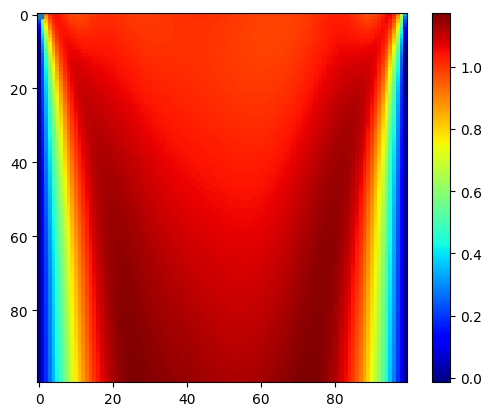

In [ ]:
sns.kdeplot(x=x_test.cpu().detach().numpy().squeeze(), y=y_test.cpu().detach().numpy().squeeze(),
            )
plt.imshow(u_test.cpu().detach().numpy().reshape(100,100), cmap='jet')
plt.colorbar()

<ipython-input-26-5b61c16e017d>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_test.cpu().detach().numpy().squeeze(), y=y_test.cpu().detach().numpy().squeeze(),


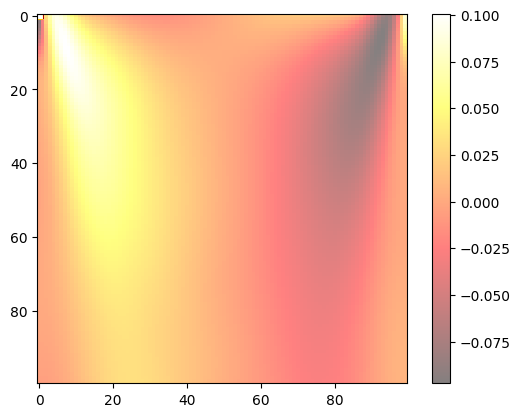

In [ ]:
sns.kdeplot(x=x_test.cpu().detach().numpy().squeeze(), y=y_test.cpu().detach().numpy().squeeze(),
            cmap='hot', shade=True)
plt.imshow(v_test.cpu().detach().numpy().reshape(100,100), cmap='hot', alpha=0.5,)
plt.colorbar()